# Metriq Data Analysis Tutorial

Welcome! This notebook will show you how to work with the metriq-data benchmark dataset. Think of it as a starting point for your own analyses of quantum computing device performance.

## What is this dataset?

The metriq-data repository collects benchmark results from quantum computers across different providers:
- **IBM** quantum systems
- **AWS Braket** devices  
- **Quantinuum** processors
- **Origin Quantum** machines

Each time a benchmark runs on a device, it saves the results as a JSON file with performance metrics.

> **A note on "raw" vs "aggregated" data:** We're working with the original benchmark files here (the source data). There's also a `scripts/aggregate.py` tool that processes these files into summary reports in the `dist/` folder, but that's separate from what we're doing in this tutorial.

## What you'll learn

- Navigate the folder structure and find data
- Load and parse benchmark JSON files
- Understand the data schema  
- Extract the information you need
- Compare devices side-by-side

## 1. Setup

First, let's import what we need:

In [15]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. What data is available?

Let's see what we have in the repository. We'll look at v0.6 since it uses the newest data format.

In [5]:
# Define the base path (go up one level since we're in notebooks/ folder)
base_path = Path('../metriq-gym/v0.6')

# Discover available providers and devices
print("Available Data in v0.6:\n" + "="*60)

for provider_dir in sorted(base_path.iterdir()):
    if not provider_dir.is_dir():
        continue
    
    provider_name = provider_dir.name
    print(f"\n{provider_name.upper()}:")
    
    # List devices for this provider
    devices = [d.name for d in provider_dir.iterdir() if d.is_dir()]
    
    for device in sorted(devices):
        device_path = provider_dir / device
        json_files = list(device_path.glob('*.json'))
        print(f"  {device}: {len(json_files)} benchmark files")

Available Data in v0.6:

AWS:
  arn_aws_braket_eu-north-1_device_qpu_iqm_emerald: 3 benchmark files

IBM:
  ibm_marrakesh: 1 benchmark files
  ibm_pittsburgh: 1 benchmark files
  ibm_torino: 4 benchmark files


## 3. Understanding the data format

Each JSON file contains benchmark results. Let's open one and see what it looks like:

In [8]:
# Load a sample benchmark file
sample_file = list(base_path.glob('**/*.json'))[0]
print(f"Reading: {sample_file.name}\n")

with open(sample_file, 'r') as f:
    sample_data = json.load(f)

# Display the structure
print("JSON Structure (first entry):")
print(json.dumps(sample_data[0], indent=2))

Reading: 2026-02-10_12-01-33_wit_15e6d023.json

JSON Structure (first entry):
{
  "app_version": "0.6.2.dev13+gd0c1487e5.d20260210",
  "timestamp": "2026-02-10T12:01:33.103097",
  "suite_id": null,
  "job_type": "WIT",
  "results": {
    "expectation_value": {
      "value": 0.758056640625,
      "uncertainty": 0.004731651060307721
    },
    "score": {
      "value": 0.758056640625,
      "uncertainty": 0.004731651060307721
    }
  },
  "runtime_seconds": 3.274848,
  "platform": {
    "device": "ibm_marrakesh",
    "device_metadata": {
      "num_qubits": 156,
      "simulator": false,
      "version": "1.0.20"
    },
    "provider": "ibm"
  },
  "params": {
    "benchmark_name": "WIT",
    "num_qubits": 7,
    "shots": 8192
  }
}


### What's inside?

The important fields in each benchmark file:

**Basic info:**
- `timestamp` — when the benchmark ran
- `job_type` — what benchmark was run (e.g., "Linear Ramp QAOA", "WIT")
- `runtime_seconds` — how long it took

**Device info (`platform`):**
- `device` — device name like "ibm_torino"
- `provider` — who operates it ("ibm", "aws", etc.)
- `device_metadata` — specs like qubit count, whether it's a simulator

**Performance (`results`):**
- `score` — the main metric (usually includes value and uncertainty)
- Other metrics that vary depending on the benchmark

**Configuration (`params`):**
- Settings used for this benchmark run

## 4. Loading the data

Now let's write some helper functions to load benchmarks. These functions can filter by provider or device, and convert the JSON into a pandas DataFrame that's easier to work with.

In [9]:
def load_benchmark_data(path, provider=None, device=None):
    """
    Load benchmark data from JSON files.
    
    Args:
        path: Base path (e.g., Path('metriq-gym/v0.6'))
        provider: Optional provider filter (e.g., 'ibm')
        device: Optional device filter (e.g., 'ibm_torino')
    
    Returns:
        List of benchmark records (flattened from all JSON files)
    """
    records = []
    
    # Build search pattern
    if provider and device:
        search_pattern = f"{provider}/{device}/*.json"
    elif provider:
        search_pattern = f"{provider}/**/*.json"
    else:
        search_pattern = "**/*.json"
    
    # Load all matching files
    for json_file in path.glob(search_pattern):
        with open(json_file, 'r') as f:
            data = json.load(f)
            
        # Each file may contain multiple benchmark entries
        if isinstance(data, list):
            records.extend(data)
        else:
            records.append(data)
    
    return records


def records_to_dataframe(records):
    """
    Convert benchmark records to a pandas DataFrame with flattened structure.
    
    This function extracts the most commonly used fields across all benchmark types.
    """
    rows = []
    
    for record in records:
        # Extract platform info
        platform = record.get('platform', {})
        device_meta = platform.get('device_metadata', {})
        
        # Extract score (primary performance metric)
        results = record.get('results', {})
        score_data = results.get('score', {})
        
        if isinstance(score_data, dict):
            score_value = score_data.get('value')
            score_uncertainty = score_data.get('uncertainty')
        else:
            score_value = score_data
            score_uncertainty = None
        
        # Build row
        row = {
            'timestamp': record.get('timestamp'),
            'job_type': record.get('job_type'),
            'device': platform.get('device'),
            'provider': platform.get('provider'),
            'num_qubits': device_meta.get('num_qubits'),
            'simulator': device_meta.get('simulator', False),
            'score': score_value,
            'score_uncertainty': score_uncertainty,
            'runtime_seconds': record.get('runtime_seconds'),
        }
        
        # Store the full record for detailed analysis
        row['_raw'] = record
        
        rows.append(row)
    
    df = pd.DataFrame(rows)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    return df


# Example: Load all IBM data
print("Loading IBM benchmark data...")
ibm_records = load_benchmark_data(base_path, provider='ibm')
ibm_df = records_to_dataframe(ibm_records)

print(f"\nLoaded {len(ibm_df)} benchmark results from IBM devices")
print(f"\nDevices: {', '.join(sorted(ibm_df['device'].unique()))}")
print(f"Benchmark types: {', '.join(sorted(ibm_df['job_type'].unique()))}")
print(f"\nDate range: {ibm_df['timestamp'].min()} to {ibm_df['timestamp'].max()}")

Loading IBM benchmark data...

Loaded 6 benchmark results from IBM devices

Devices: ibm_marrakesh, ibm_pittsburgh, ibm_torino
Benchmark types: Linear Ramp QAOA, WIT

Date range: 2026-02-10 12:01:33.103097 to 2026-02-10 17:02:27.624611


### Taking a look at what we loaded

In [10]:
# Display basic statistics
print("DataFrame Info:")
print(f"Shape: {ibm_df.shape}")
print(f"\nColumns: {list(ibm_df.columns[:8])}  # excluding '_raw'")

# Show sample rows (excluding the raw data column for readability)
print("\nSample Data:")
ibm_df.drop(columns=['_raw']).head(3)

DataFrame Info:
Shape: (6, 10)

Columns: ['timestamp', 'job_type', 'device', 'provider', 'num_qubits', 'simulator', 'score', 'score_uncertainty']  # excluding '_raw'

Sample Data:


,timestamp,job_type,device,provider,num_qubits,simulator,score,score_uncertainty,runtime_seconds
0,2026-02-10 12:01:33.103097,WIT,ibm_marrakesh,ibm,156,False,0.758057,0.004732,3.274848
1,2026-02-10 12:02:13.684154,WIT,ibm_pittsburgh,ibm,156,False,0.888184,0.003482,6.460073
2,2026-02-10 16:56:45.296275,Linear Ramp QAOA,ibm_torino,ibm,133,False,0.576950,NaN,3.558766


In [11]:
# Summary statistics by device
print("Benchmark Counts by Device and Type:\n")
summary = ibm_df.groupby(['device', 'job_type']).size().unstack(fill_value=0)
print(summary)

print("\n" + "="*60)
print("Score Statistics by Device:\n")
score_stats = ibm_df.groupby('device')['score'].agg(['count', 'mean', 'std', 'min', 'max'])
print(score_stats.round(3))

Benchmark Counts by Device and Type:

job_type        Linear Ramp QAOA  WIT
device                               
ibm_marrakesh                  0    1
ibm_pittsburgh                 0    1
ibm_torino                     4    0

Score Statistics by Device:

                count   mean    std    min    max
device                                           
ibm_marrakesh       1  0.758    NaN  0.758  0.758
ibm_pittsburgh      1  0.888    NaN  0.888  0.888
ibm_torino          4  0.518  0.049  0.456  0.577


## 5. Getting benchmark-specific metrics

Different benchmarks measure different things. The `_raw` column in our DataFrame keeps the complete original JSON, so you can always dig deeper and extract any field specific to that benchmark type.

In [12]:
# Example: Extract benchmark-specific metrics for Linear Ramp QAOA
qaoa_data = ibm_df[ibm_df['job_type'] == 'Linear Ramp QAOA'].copy()

if len(qaoa_data) > 0:
    print("Linear Ramp QAOA specific metrics:\n")
    
    # Extract additional metrics from raw data
    qaoa_data['approx_ratio'] = qaoa_data['_raw'].apply(
        lambda x: x.get('results', {}).get('approx_ratio', [None])[0]
    )
    qaoa_data['random_approx_ratio'] = qaoa_data['_raw'].apply(
        lambda x: x.get('results', {}).get('random_approx_ratio')
    )
    qaoa_data['num_qubits_param'] = qaoa_data['_raw'].apply(
        lambda x: x.get('params', {}).get('num_qubits')
    )
    
    # Display
    cols_to_show = ['device', 'timestamp', 'score', 'approx_ratio', 'random_approx_ratio', 'num_qubits_param']
    print(qaoa_data[cols_to_show].head())
else:
    print("No Linear Ramp QAOA data found in this subset.")

Linear Ramp QAOA specific metrics:

       device                  timestamp     score  approx_ratio  \
2  ibm_torino 2026-02-10 16:56:45.296275  0.576950      0.788433   
3  ibm_torino 2026-02-10 16:57:48.069239  0.517461      0.759101   
4  ibm_torino 2026-02-10 17:00:06.206238  0.521750      0.767560   
5  ibm_torino 2026-02-10 17:02:27.624611  0.455970      0.734502   

   random_approx_ratio  num_qubits_param  
2             0.499901                10  
3             0.500769                20  
4             0.513977                50  
5             0.511979               100  


## 6. Comparing devices

Now for the fun part — let's see how different devices stack up against each other!

Benchmark types by device coverage:
job_type
WIT                 2
Linear Ramp QAOA    1
Name: device, dtype: int64

Analyzing: WIT


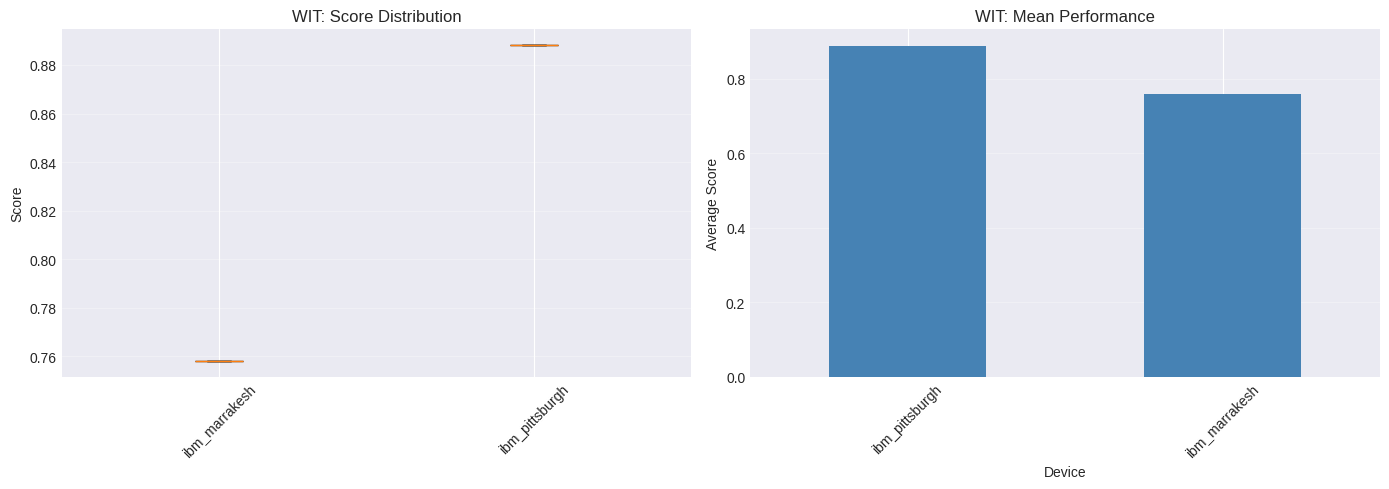


Summary Statistics for WIT:
                 mean  std  count
device                           
ibm_pittsburgh  0.888  NaN      1
ibm_marrakesh   0.758  NaN      1


In [14]:
# Select a benchmark type that has data across multiple devices
benchmark_counts = ibm_df.groupby('job_type')['device'].nunique().sort_values(ascending=False)
print("Benchmark types by device coverage:")
print(benchmark_counts)

# Use the benchmark with most device coverage
if len(benchmark_counts) > 0:
    selected_benchmark = benchmark_counts.index[0]
    print(f"\nAnalyzing: {selected_benchmark}")
    
    # Filter data
    benchmark_df = ibm_df[ibm_df['job_type'] == selected_benchmark].copy()
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Score distribution by device
    ax1 = axes[0]
    devices = benchmark_df['device'].unique()
    data_by_device = [benchmark_df[benchmark_df['device'] == d]['score'].dropna() for d in devices]
    
    if any(len(d) > 0 for d in data_by_device):
        bp = ax1.boxplot([d for d in data_by_device if len(d) > 0], 
                         tick_labels=[devices[i] for i, d in enumerate(data_by_device) if len(d) > 0],
                         patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        ax1.set_ylabel('Score')
        ax1.set_title(f'{selected_benchmark}: Score Distribution')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Average scores with error bars
    ax2 = axes[1]
    device_stats = benchmark_df.groupby('device')['score'].agg(['mean', 'std', 'count'])
    device_stats = device_stats[device_stats['count'] > 0].sort_values('mean', ascending=False)
    
    if len(device_stats) > 0:
        device_stats.plot(kind='bar', y='mean', yerr='std', ax=ax2, 
                         color='steelblue', legend=False, capsize=4)
        ax2.set_ylabel('Average Score')
        ax2.set_title(f'{selected_benchmark}: Mean Performance')
        ax2.set_xlabel('Device')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nSummary Statistics for {selected_benchmark}:")
    print(device_stats.round(3))
else:
    print("No benchmark data available for comparison.")

## Where to go from here

You now know how to:
- Find your way around the dataset
- Load benchmark files and parse them into DataFrames
- Extract what you need from the results
- Compare device performance

### Ideas for your own analysis

**Try different data:**
- Switch to `v0.4` or `v0.5` if you want to look at older benchmarks
- Focus on one benchmark type by filtering on `job_type`
- Compare AWS, Quantinuum, or Origin Quantum devices

**Dig deeper:**
- Use the `_raw` column to extract benchmark-specific metrics we didn't cover here
- Track how performance changes over time using the `timestamp` field
- Work with the pre-processed summaries in `dist/` (generated by `scripts/aggregate.py`)

### Things to keep in mind

- Not all devices have the same amount of data
- Each benchmark type uses different score ranges and definitions
- Some benchmarks have extra metrics beyond what we put in the DataFrame
- Always check you have enough data before drawing conclusions

Happy analyzing!